In [1]:
#1. Definicao das bibliotecas
%%capture
!pip install neupy
!pip install tensorflow
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from warnings import filterwarnings
from sklearn import model_selection
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from neupy import algorithms
from sklearn.svm import SVC
from sklearn import tree
from scipy import stats
import seaborn as sns
import numpy as np
import pandas
filterwarnings('ignore')

In [2]:
#2. Definicao da semente para geracao de numereos aleatorios
seed = 7

#3. Leitura dos dados
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
dt_parameters = ['Male','Age','Debt','Married','BankCustomer','EducationLevel','Ethnicity','YearsEmployed','PriorDefault','Employed','CreditScore','DriversLicense','Citizen','ZipCode','Income','Approved']

dataframe = pandas.read_csv(url, delimiter=",", names=dt_parameters)

#4. A analise exploratoria dos dados realizada em outro script

# Tratamento dos dados

In [3]:
# CONVERTENDO COLUNA Age EM NUMÉRICO

dataframe_inc = dataframe[dataframe['Age'] == '?'] #Pegar valores inconsistentes em Age
dataframe    =  dataframe[dataframe['Age'] != '?'] #Pegar valores consistentes em Age

dataframe.Age = dataframe.Age.astype(np.float32) #Convertendo atributo Age para numérico
dataframe_inc.loc[(dataframe_inc['Age'] == '?'), 'Age'] = dataframe['Age'].mode() #Inserindo a moda de Age nas instâncias inconsistentes
dataframe_inc.Age = dataframe_inc.Age.astype(np.float32)
dataframe = pandas.concat([dataframe, dataframe_inc], axis=0) #Concatenando e finalizando ajuste

In [4]:
dataframe.sort_index(ascending=True, inplace=True)
dataframe.replace('?', np.nan, inplace = True) # Substituindo as interrogações por um valor numérico nulo

In [5]:
# TRATANDO DADOS NUMÉRICOS
def mean_norm(dataset):
    return numerics_dataframe.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

numerics_dataframe = dataframe[['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']]
numerics_dataframe.interpolate(inplace = True, method='linear') # Interpolando os valores numéricos nulos
numerics_dataframe = mean_norm(numerics_dataframe)
numerics_dataframe

,Age,Debt,YearsEmployed,CreditScore,Income
0,-0.059715,-0.955920,-0.290872,-0.287892,-0.195272
1,2.279601,-0.060007,0.244013,0.740293,-0.087788
2,-0.591607,-0.855481,-0.216167,-0.493529,-0.037117
3,-0.311797,-0.646569,0.456175,0.534656,-0.194696
4,-0.955445,0.174015,-0.153415,-0.493529,-0.195272
...,...,...,...,...,...
685,-0.878980,1.069928,-0.290872,-0.493529,-0.195272
686,-0.745377,-0.805262,-0.066758,-0.082255,-0.119649
687,-0.528587,1.755924,-0.066758,-0.287892,-0.195080
688,-1.144506,-0.914740,-0.652442,-0.493529,-0.051321


In [6]:
dataframe.shape

(690, 16)

In [7]:
dataframe.reset_index(drop=True, inplace=True)

# CONVERTENDO CLASSE PARA VALORES BOOLEANOS
dataframe['Approved'].replace(['+', '-'],
                        [1, 0], inplace=True)

# SEPARANDO CLASSE QUE VAMOS REALIZAR A PREDIÇÃO
class_dataframe = dataframe[['Approved']]

In [8]:
# SELEÇÃO DE DADOS CATEGÓRICOS
attr_drop=  ['Ethnicity', 'ZipCode'] # Removendo dados de etnia e código postal
for attr in attr_drop:
  dataframe.drop(attr, axis=1, inplace=True)

In [9]:
# CONVERTENDO VALORES CATEGÓRICOS EM NUMÉRICOS (BINÁRIOS)
onehotenconder = OneHotEncoder() 

print("selecionar apenas as colunas que sao do tipo objeto/categorigos\n")
categorical_dataframe = dataframe.select_dtypes(include=['object']).copy()

print(categorical_dataframe.isnull().sum()) # Soma de valores nulos de atributos categóricos

# SUBSTITUINDO VALORES NULOS PELA MODA
for col in categorical_dataframe.columns.values.tolist():
  dataframe[col] = dataframe[col].fillna(dataframe[col].mode()[0])

categorical_dataframe = dataframe.select_dtypes(include=['object']).copy()
categorical_dataframe_ohe = onehotenconder.fit_transform(categorical_dataframe).toarray()
print(f'Os {categorical_dataframe.shape[1]} atributos categóricos foram transformados em {categorical_dataframe_ohe.shape[1]} Colunas')

feature_names_ohe = onehotenconder.get_feature_names(categorical_dataframe.columns)
categorical_dataframe_ohe = pandas.DataFrame(categorical_dataframe_ohe, columns=feature_names_ohe)

selecionar apenas as colunas que sao do tipo objeto/categorigos

Male              12
Married            6
BankCustomer       6
EducationLevel     9
PriorDefault       0
Employed           0
DriversLicense     0
Citizen            0
dtype: int64
Os 8 atributos categóricos foram transformados em 31 Colunas


In [10]:
dataframe = pandas.concat([categorical_dataframe_ohe, numerics_dataframe], axis=1) #Uma coluna ao lado da outra
dataframe

,Male_a,Male_b,Married_l,Married_u,Married_y,BankCustomer_g,BankCustomer_gg,BankCustomer_p,EducationLevel_aa,EducationLevel_c,...,DriversLicense_f,DriversLicense_t,Citizen_g,Citizen_p,Citizen_s,Age,Debt,YearsEmployed,CreditScore,Income
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,-0.059715,-0.955920,-0.290872,-0.287892,-0.195272
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,2.279601,-0.060007,0.244013,0.740293,-0.087788
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,-0.591607,-0.855481,-0.216167,-0.493529,-0.037117
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,-0.311797,-0.646569,0.456175,0.534656,-0.194696
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,-0.955445,0.174015,-0.153415,-0.493529,-0.195272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,-0.878980,1.069928,-0.290872,-0.493529,-0.195272
686,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,-0.745377,-0.805262,-0.066758,-0.082255,-0.119649
687,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,-0.528587,1.755924,-0.066758,-0.287892,-0.195080
688,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,-1.144506,-0.914740,-0.652442,-0.493529,-0.051321


In [11]:
 dataframe.isnull().sum()# Validando o tratamento de nulos

Male_a               0
Male_b               0
Married_l            0
Married_u            0
Married_y            0
BankCustomer_g       0
BankCustomer_gg      0
BankCustomer_p       0
EducationLevel_aa    0
EducationLevel_c     0
EducationLevel_cc    0
EducationLevel_d     0
EducationLevel_e     0
EducationLevel_ff    0
EducationLevel_i     0
EducationLevel_j     0
EducationLevel_k     0
EducationLevel_m     0
EducationLevel_q     0
EducationLevel_r     0
EducationLevel_w     0
EducationLevel_x     0
PriorDefault_f       0
PriorDefault_t       0
Employed_f           0
Employed_t           0
DriversLicense_f     0
DriversLicense_t     0
Citizen_g            0
Citizen_p            0
Citizen_s            0
Age                  0
Debt                 0
YearsEmployed        0
CreditScore          0
Income               0
dtype: int64

# Testando modelos

In [12]:

#5. Preparacao dos dados conduzida em outro script
print("Apresentando o shape dos dados (dimenssoes)")
print(dataframe.shape)
array = dataframe.values

#6. Divisao da base de dados em treinamento, validacao e teste
X_train, X_test, y_train, y_test = train_test_split(dataframe, class_dataframe, random_state=seed)
X_train_p, X_valid, y_train_p, y_valid = train_test_split(X_train, y_train, random_state=seed)

# define evaluation
cv = model_selection.StratifiedKFold(n_splits=10)

Apresentando o shape dos dados (dimenssoes)
(690, 36)


## Realizar busca com o gridsearch ou randonsearhc para encontrar os melhores parametros de cada modelo

In [15]:
def definir_n_iter(combinacoes):
  if combinacoes >= 100:
    return range(10, 110, 10)
  
  if combinacoes >= 50:
    return range(5, 55, 5)
  
  if combinacoes >= 20:
    return range(2, 22, 2)
  else:
    return range(2, 14)

### LVQ

#### Teste 1


In [ ]:
param_lvq = {'step': [0.1, 0.3, 0.5, 0.7, 0.9]}

In [ ]:
lvq_best_scores = (0, {}, None)

for n_subclasses, prototypes_per_class in [(6, [3,3]), (8, [4,4]), (10, [5,5]), (12, [6,6])]:
  lvqnet = algorithms.LVQ(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=n_subclasses, prototypes_per_class = prototypes_per_class)
  for i in range(1, len(param_lvq['step'])):
    search_lvq = RandomizedSearchCV(lvqnet, param_lvq, n_iter=i, scoring='accuracy', n_jobs =4, cv=cv, random_state=seed)
    result_lvq = search_lvq.fit(X_train, y_train)
    print('=========Random Search Results for LVQ Teste 1==========')
    best_params = result_lvq.best_params_
    best_params['n_subclasses'] = n_subclasses
    best_params['prototypes_per_class'] = prototypes_per_class
    print('Best Score: %s' % result_lvq.best_score_)
    print('Best Hyperparameters: %s' % best_params)
    if result_lvq.best_score_ > lvq_best_scores[0]:
      best_params = result_lvq.best_params_
      best_params['n_subclasses'] = n_subclasses
      best_params['prototypes_per_class'] = prototypes_per_class
      lvq_best_scores = (result_lvq.best_score_, best_params, result_lvq)

=========Random Search Results for LVQ Teste 1==========
Best Score: 0.8318627450980391
Best Hyperparameters: {'step': 0.1, 'n_subclasses': 6, 'prototypes_per_class': [3, 3]}
=========Random Search Results for LVQ Teste 1==========
Best Score: 0.8277903469079939
Best Hyperparameters: {'step': 0.1, 'n_subclasses': 6, 'prototypes_per_class': [3, 3]}
=========Random Search Results for LVQ Teste 1==========
Best Score: 0.8259803921568627
Best Hyperparameters: {'step': 0.1, 'n_subclasses': 6, 'prototypes_per_class': [3, 3]}
=========Random Search Results for LVQ Teste 1==========
Best Score: 0.8220588235294117
Best Hyperparameters: {'step': 0.1, 'n_subclasses': 6, 'prototypes_per_class': [3, 3]}
=========Random Search Results for LVQ Teste 1==========
Best Score: 0.8219457013574661
Best Hyperparameters: {'step': 0.1, 'n_subclasses': 8, 'prototypes_per_class': [4, 4]}
=========Random Search Results for LVQ Teste 1==========
Best Score: 0.8335218702865763
Best Hyperparameters: {'step': 0.1, '

In [ ]:
print('=========Random Search Results for LVQ - Teste 1==========')
print(f'Best Score: {round(lvq_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters:  {lvq_best_scores[1]}')
result_lvq = lvq_best_scores[2]

=========Random Search Results for LVQ - Teste 1==========
Best Score: 83.3522%
Best Hyperparameters:  {'step': 0.1, 'n_subclasses': 8, 'prototypes_per_class': [4, 4]}


#### Teste 2

In [ ]:
param_lvq = {'step': [0.01, 0.03, 0.05, 0.07, 0.1]}

In [ ]:
lvq_best_scores = (0, {}, None)
best_scores_count = {'step': 0, 'n_subclasses': 0, 'prototypes_per_class': 0}

for n_subclasses, prototypes_per_class in [(8, [4,4]), (10, [5,5]), (12, [6,6]), (14, [7, 7])]:
  lvqnet = algorithms.LVQ(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=n_subclasses, prototypes_per_class = prototypes_per_class)
  for i in range(1, len(param_lvq['step'])):
    search_lvq = RandomizedSearchCV(lvqnet, param_lvq, n_iter=i, scoring='accuracy', n_jobs =4, cv=cv, random_state=seed)
    result_lvq = search_lvq.fit(X_train, y_train)
    print('=========Random Search Results for LVQ Teste 2==========')
    best_params = result_lvq.best_params_
    best_params['n_subclasses'] = n_subclasses
    best_params['prototypes_per_class'] = prototypes_per_class

    print('Best Score: %s' % result_lvq.best_score_)
    print('Best Hyperparameters: %s' % best_params)
    if result_lvq.best_score_ > lvq_best_scores[0]:
      best_params = result_lvq.best_params_
      best_params['n_subclasses'] = n_subclasses
      best_params['prototypes_per_class'] = prototypes_per_class
      lvq_best_scores = (result_lvq.best_score_, best_params, result_lvq)

=========Random Search Results for LVQ Teste 2==========
Best Score: 0.8394042232277528
Best Hyperparameters: {'step': 0.01, 'n_subclasses': 8, 'prototypes_per_class': [4, 4]}
=========Random Search Results for LVQ Teste 2==========
Best Score: 0.8316742081447964
Best Hyperparameters: {'step': 0.01, 'n_subclasses': 8, 'prototypes_per_class': [4, 4]}
=========Random Search Results for LVQ Teste 2==========
Best Score: 0.8259426847662142
Best Hyperparameters: {'step': 0.05, 'n_subclasses': 8, 'prototypes_per_class': [4, 4]}
=========Random Search Results for LVQ Teste 2==========
Best Score: 0.8394419306184012
Best Hyperparameters: {'step': 0.07, 'n_subclasses': 8, 'prototypes_per_class': [4, 4]}
=========Random Search Results for LVQ Teste 2==========
Best Score: 0.831636500754148
Best Hyperparameters: {'step': 0.01, 'n_subclasses': 10, 'prototypes_per_class': [5, 5]}
=========Random Search Results for LVQ Teste 2==========
Best Score: 0.8316742081447964
Best Hyperparameters: {'step': 0

In [ ]:
print('=========Random Search Results for LVQ - Teste 2==========')
print(f'Best Score: {round(lvq_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters:  {lvq_best_scores[1]}')
result_lvq = lvq_best_scores[2]

=========Random Search Results for LVQ - Teste 2==========
Best Score: 84.902%
Best Hyperparameters:  {'step': 0.07, 'n_subclasses': 14, 'prototypes_per_class': [7, 7]}


### SVC

#### Teste 1

In [ ]:
svc = SVC()
param_svc = {'C': [0.1, 1, 10,],
              'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto'],
              'kernel': ['rbf', 'linear', 'sigmoid','poly'],
              'decision_function_shape': ['ovo','ovr']
              }

In [ ]:
# define random search for SVM
param_svc_max_n_iter = len(param_svc['C']) * len(param_svc['gamma']) * len(param_svc['kernel']) * len(param_svc['decision_function_shape'])
for_range = definir_n_iter(param_svc_max_n_iter)
svc_best_scores = (0, {}, None)
for i in for_range:
  search_svc = RandomizedSearchCV(svc, param_svc, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_svc = search_svc.fit(X_train, y_train)
  print('=========Random Search Results for SVM Teste 1==========')
  print('Best Score: %s' % result_svc.best_score_)
  print('Best Hyperparameters: %s' % result_svc.best_params_)
  if result_svc.best_score_ > svc_best_scores[0]:
    svc_best_scores = (result_svc.best_score_, result_svc.best_params_, result_svc)

=========Random Search Results for SVM Teste 1==========
Best Score: 0.8549019607843137
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovo', 'C': 10}
=========Random Search Results for SVM Teste 1==========
Best Score: 0.8549019607843137
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovo', 'C': 10}
=========Random Search Results for SVM Teste 1==========
Best Score: 0.8549019607843137
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovo', 'C': 10}
=========Random Search Results for SVM Teste 1==========
Best Score: 0.8568250377073907
Best Hyperparameters: {'kernel': 'poly', 'gamma': 0.1, 'decision_function_shape': 'ovr', 'C': 1}
=========Random Search Results for SVM Teste 1==========
Best Score: 0.8568250377073907
Best Hyperparameters: {'kernel': 'poly', 'gamma': 0.1, 'decision_function_shape': 'ovr', 'C': 1}
=========Random Search Results for SVM Teste 1==========
Best Scor

In [ ]:
print('=========Random Search Results for SVM Teste 1==========')
print(f'Best Score: {round(svc_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters:  {svc_best_scores[1]}')
result_svc = svc_best_scores[2]

=========Random Search Results for SVM Teste 1==========
Best Score: 86.4442%
Best Hyperparameters:  {'kernel': 'poly', 'gamma': 0.1, 'decision_function_shape': 'ovo', 'C': 0.1}


#### Teste 2

In [ ]:
svc = SVC()
param_svc = {'C': [0.1, 1, 10, 25, 50],
              'gamma': [0.01, 0.05, 0.07, 'auto'],
              'kernel': ['rbf','poly'],
              'decision_function_shape': ['ovo','ovr']
              }

In [ ]:
# define random search for SVM
param_svc_max_n_iter = len(param_svc['C']) * len(param_svc['gamma']) * len(param_svc['kernel']) * len(param_svc['decision_function_shape'])
for_range = definir_n_iter(param_svc_max_n_iter)
svc_best_scores = (0, {}, None)
for i in for_range:
  search_svc = RandomizedSearchCV(svc, param_svc, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_svc = search_svc.fit(X_train, y_train)
  print('=========Random Search Results for SVM Teste 2==========')
  print('Best Score: %s' % result_svc.best_score_)
  print('Best Hyperparameters: %s' % result_svc.best_params_)
  if result_svc.best_score_ > svc_best_scores[0]:
    svc_best_scores = (result_svc.best_score_, result_svc.best_params_, result_svc)

=========Random Search Results for SVM Teste 2==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 2==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 2==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 2==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 2==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 2==========
Bes

In [ ]:
print('=========Random Search Results for SVM Teste 2==========')
print(f'Best Score: {round(svc_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters:  {svc_best_scores[1]}')
result_svc = svc_best_scores[2]

=========Random Search Results for SVM Teste 2==========
Best Score: 87.417%
Best Hyperparameters:  {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}


#### Teste 3

In [ ]:
svc = SVC()
param_svc = {'C': [25, 30, 35, 40],
              'gamma': ['auto'],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovr']
              }

In [ ]:
# define random search for SVM
param_svc_max_n_iter = len(param_svc['C']) * len(param_svc['gamma']) * len(param_svc['kernel']) * len(param_svc['decision_function_shape'])
for_range = definir_n_iter(param_svc_max_n_iter)
svc_best_scores = (0, {}, None)
for i in for_range:
  search_svc = RandomizedSearchCV(svc, param_svc, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_svc = search_svc.fit(X_train, y_train)
  print('=========Random Search Results for SVM Teste 3==========')
  print('Best Score: %s' % result_svc.best_score_)
  print('Best Hyperparameters: %s' % result_svc.best_params_)
  if result_svc.best_score_ > svc_best_scores[0]:
    svc_best_scores = (result_svc.best_score_, result_svc.best_params_, result_svc)

=========Random Search Results for SVM Teste 3==========
Best Score: 0.872209653092006
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 35}
=========Random Search Results for SVM Teste 3==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 3==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 3==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 3==========
Best Score: 0.8741704374057315
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}
=========Random Search Results for SVM Teste 3==========
Best

In [ ]:
print('=========Random Search Results for SVM Teste 3==========')
print(f'Best Score: {round(svc_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters:  {svc_best_scores[1]}')
result_svc = svc_best_scores[2]

=========Random Search Results for SVM Teste 3==========
Best Score: 87.417%
Best Hyperparameters:  {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 25}


### Decision Tree

#### Teste 1

In [ ]:
decisionTree = DecisionTreeClassifier()
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [2,3,5,7]
space['max_depth'] = [3,5,6,7,9,11,13,15,17,19]
space['min_samples_leaf'] = [2, 3]

In [ ]:
space_max_n_iter = len(space['criterion']) * len(space['min_samples_split']) * len(space['max_depth']) * len(space['min_samples_leaf'])
for_range = definir_n_iter(space_max_n_iter)
tree_best_scores = (0, {}, None)
for i in for_range:
  search_tree = RandomizedSearchCV(decisionTree, space, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_tree = search_tree.fit(X_train, y_train)
  print('=========Random Search Results fro TREE Teste 1==========')
  print('Best Score: %s' % result_tree.best_score_)
  print('Best Hyperparameters: %s' % result_tree.best_params_)
  if result_tree.best_score_ > tree_best_scores[0]:
    tree_best_scores = (result_tree.best_score_, result_tree.best_params_, result_tree)

=========Random Search Results fro TREE Teste 1==========
Best Score: 0.8432126696832579
Best Hyperparameters: {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 1==========
Best Score: 0.8433634992458522
Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 1==========
Best Score: 0.8413273001508296
Best Hyperparameters: {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 1==========
Best Score: 0.8451357466063347
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 1==========
Best Score: 0.8453242835595777
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
=====

In [ ]:
print('=========Random Search Results from TREE Teste 1==========')
print(f'Best Score: {round(tree_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {tree_best_scores[1]}')
result_tree = tree_best_scores[2]

=========Random Search Results from TREE Teste 1==========
Best Score: 84.7059%
Best Hyperparameters: {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 17, 'criterion': 'entropy'}


#### Teste 2

In [ ]:
decisionTree = DecisionTreeClassifier()
space = dict()
space['criterion'] = ['entropy']
space['min_samples_split'] = [5, 6, 7]
space['max_depth'] = [5, 6, 8, 9]
space['min_samples_leaf'] = [2]

In [ ]:
space_max_n_iter = len(space['criterion']) * len(space['min_samples_split']) * len(space['max_depth']) * len(space['min_samples_leaf'])
for_range = definir_n_iter(space_max_n_iter)
tree_best_scores = (0, {}, None)
for i in for_range:
  search_tree = RandomizedSearchCV(decisionTree, space, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_tree = search_tree.fit(X_train, y_train)
  print('=========Random Search Results fro TREE Teste 2==========')
  print('Best Score: %s' % result_tree.best_score_)
  print('Best Hyperparameters: %s' % result_tree.best_params_)
  if result_tree.best_score_ > tree_best_scores[0]:
    tree_best_scores = (result_tree.best_score_, result_tree.best_params_, result_tree)

=========Random Search Results fro TREE Teste 2==========
Best Score: 0.8509049773755656
Best Hyperparameters: {'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 2==========
Best Score: 0.8453242835595777
Best Hyperparameters: {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 2==========
Best Score: 0.8470211161387631
Best Hyperparameters: {'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 2==========
Best Score: 0.8453242835595777
Best Hyperparameters: {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 2==========
Best Score: 0.8453242835595777
Best Hyperparameters: {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
=====

In [ ]:
print('=========Random Search Results from TREE Teste 2==========')
print(f'Best Score: {round(tree_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {tree_best_scores[1]}')
result_tree = tree_best_scores[2]

=========Random Search Results from TREE Teste 2==========
Best Score: 85.0905%
Best Hyperparameters: {'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}


#### Teste 3

In [ ]:
decisionTree = DecisionTreeClassifier()
space = dict()
space['criterion'] = ['entropy']
space['min_samples_split'] = [5, 6, 7]
space['max_depth'] = [5, 8]
space['min_samples_leaf'] = [2]

In [ ]:
space_max_n_iter = len(space['criterion']) * len(space['min_samples_split']) * len(space['max_depth']) * len(space['min_samples_leaf'])
for_range = definir_n_iter(space_max_n_iter)
tree_best_scores = (0, {}, None)
for i in for_range:
  search_tree = RandomizedSearchCV(decisionTree, space, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_tree = search_tree.fit(X_train, y_train)
  print('=========Random Search Results fro TREE Teste 3==========')
  print('Best Score: %s' % result_tree.best_score_)
  print('Best Hyperparameters: %s' % result_tree.best_params_)
  if result_tree.best_score_ > tree_best_scores[0]:
    tree_best_scores = (result_tree.best_score_, result_tree.best_params_, result_tree)

=========Random Search Results fro TREE Teste 3==========
Best Score: 0.8451357466063347
Best Hyperparameters: {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 3==========
Best Score: 0.8453242835595777
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 3==========
Best Score: 0.8469834087481146
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 3==========
Best Score: 0.8509049773755656
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}
=========Random Search Results fro TREE Teste 3==========
Best Score: 0.8508672699849171
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}
=====

In [ ]:
print('=========Random Search Results from TREE Teste 3==========')
print(f'Best Score: {round(tree_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {tree_best_scores[1]}')
result_tree = tree_best_scores[2]

=========Random Search Results from TREE Teste 3==========
Best Score: 85.0905%
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy'}


### KNN

#### Teste 1

In [ ]:
knn = KNeighborsClassifier()
knn_param = dict()
knn_param['n_neighbors'] = range(4,11)
knn_param['weights'] = ['uniform', 'distance']
knn_param['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']
knn_param['metric'] = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']

In [ ]:
knn_max_n_iter = len(knn_param['n_neighbors']) * len(knn_param['weights']) * len(knn_param['algorithm']) * len(knn_param['metric'])
for_range = definir_n_iter(knn_max_n_iter)

knn_best_scores = (0, {}, None)
for i in for_range:
  search_knn = RandomizedSearchCV(knn, knn_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_knn = search_knn.fit(X_train, y_train)
  print('=========Random Search Results for KNN Teste 1==========')
  print('Best Score: %s' % result_knn.best_score_)
  print('Best Hyperparameters: %s' % result_knn.best_params_)

  if result_knn.best_score_ > knn_best_scores[0]:
    knn_best_scores = (result_knn.best_score_, result_knn.best_params_, result_knn)

=========Random Search Results for KNN Teste 1==========
Best Score: 0.847058823529412
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========Random Search Results for KNN Teste 1==========
Best Score: 0.847058823529412
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========Random Search Results for KNN Teste 1==========
Best Score: 0.847058823529412
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========Random Search Results for KNN Teste 1==========
Best Score: 0.847058823529412
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========Random Search Results for KNN Teste 1==========
Best Score: 0.847058823529412
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========R

In [ ]:
print('=========Random Search Results for KNN Teste 1==========')
print(f'Best Score: {round(knn_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {knn_best_scores[1]}')
result_knn = knn_best_scores[2]

=========Random Search Results for KNN Teste 1==========
Best Score: 85.6825%
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan', 'algorithm': 'auto'}


#### Teste 2

In [ ]:
knn = KNeighborsClassifier()
knn_param = dict()
knn_param['n_neighbors'] = [5, 6, 8, 9]
knn_param['weights'] = ['uniform', 'distance']
knn_param['algorithm'] = ['kd_tree']
knn_param['metric'] = ['manhattan']

In [ ]:
knn_max_n_iter = len(knn_param['n_neighbors']) * len(knn_param['weights']) * len(knn_param['algorithm']) * len(knn_param['metric'])
for_range = definir_n_iter(knn_max_n_iter)

knn_best_scores = (0, {}, None)
for i in for_range:
  search_knn = RandomizedSearchCV(knn, knn_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_knn = search_knn.fit(X_train, y_train)
  print('=========Random Search Results for KNN Teste 2==========')
  print('Best Score: %s' % result_knn.best_score_)
  print('Best Hyperparameters: %s' % result_knn.best_params_)

  if result_knn.best_score_ > knn_best_scores[0]:
    knn_best_scores = (result_knn.best_score_, result_knn.best_params_, result_knn)

=========Random Search Results for KNN Teste 2==========
Best Score: 0.850942684766214
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========Random Search Results for KNN Teste 2==========
Best Score: 0.850942684766214
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========Random Search Results for KNN Teste 2==========
Best Score: 0.8547511312217193
Best Hyperparameters: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========Random Search Results for KNN Teste 2==========
Best Score: 0.8548265460030166
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
=========Random Search Results for KNN Teste 2==========
Best Score: 0.8548265460030166
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
========

In [ ]:
print('=========Random Search Results for KNN Teste 2==========')
print(f'Best Score: {round(knn_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {knn_best_scores[1]}')
result_knn = knn_best_scores[2]

=========Random Search Results for KNN Teste 2==========
Best Score: 85.4827%
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'manhattan', 'algorithm': 'kd_tree'}


### RFC

#### Teste 1

In [ ]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param = dict()
rfc_param['n_estimators'] = [10, 30, 50, 70, 90]
rfc_param['criterion'] = ['gini', 'entropy']
rfc_param['min_samples_split'] = [2, 4, 6, 8, 10]
rfc_param['max_features'] = ['auto', 'sqrt', 'log2']
rfc_param['class_weight'] = ['balanced', 'balanced_subsample', None]

In [ ]:
rfc_max_n_iter = len(rfc_param['n_estimators']) * len(rfc_param['criterion']) * len(rfc_param['min_samples_split']) * len(rfc_param['max_features']) * len(rfc_param['class_weight'])
for_range = definir_n_iter(rfc_max_n_iter)

rfc_best_scores = (0, {}, None)
for i in for_range:
  search_rfc = RandomizedSearchCV(rfc, rfc_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_rfc = search_rfc.fit(X_train, y_train)
  print('=========Random Search Results for RFC Teste 1==========')
  print('Best Score: %s' % result_rfc.best_score_)
  print('Best Hyperparameters: %s' % result_rfc.best_params_)

  if result_rfc.best_score_ > rfc_best_scores[0]:
    rfc_best_scores = (result_rfc.best_score_, result_rfc.best_params_, result_rfc)

=========Random Search Results for RFC Teste 1==========
Best Score: 0.8722473604826547
Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 8, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
=========Random Search Results for RFC Teste 1==========
Best Score: 0.8818250377073907
Best Hyperparameters: {'n_estimators': 90, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}
=========Random Search Results for RFC Teste 1==========
Best Score: 0.8818250377073907
Best Hyperparameters: {'n_estimators': 90, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}
=========Random Search Results for RFC Teste 1==========
Best Score: 0.8818250377073907
Best Hyperparameters: {'n_estimators': 90, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}
=========Random Search Results for RFC Teste 1==========
Best Score: 0.8818250377073

In [ ]:
print('=========Random Search Results for RFC==========')
print(f'Best Score: {round(rfc_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {rfc_best_scores[1]}')
result_rfc = rfc_best_scores[2]

=========Random Search Results for RFC==========
Best Score: 88.1825%
Best Hyperparameters: {'n_estimators': 90, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}


#### Teste 2

In [ ]:
rfc = RandomForestClassifier(random_state=seed)
rfc_param = dict()
rfc_param['n_estimators'] = [90, 92, 94, 96, 98, 100, 110, 120]
rfc_param['criterion'] = ['entropy']
rfc_param['min_samples_split'] = [3, 4, 5]
rfc_param['max_features'] = ['sqrt']
rfc_param['class_weight'] = [None]

In [ ]:
rfc_max_n_iter = len(rfc_param['n_estimators']) * len(rfc_param['criterion']) * len(rfc_param['min_samples_split']) * len(rfc_param['max_features']) * len(rfc_param['class_weight'])
for_range = definir_n_iter(rfc_max_n_iter)

rfc_best_scores = (0, {}, None)
for i in for_range:
  search_rfc = RandomizedSearchCV(rfc, rfc_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_rfc = search_rfc.fit(X_train, y_train)
  print('=========Random Search Results for RFC Teste 2==========')
  print('Best Score: %s' % result_rfc.best_score_)
  print('Best Hyperparameters: %s' % result_rfc.best_params_)

  if result_rfc.best_score_ > rfc_best_scores[0]:
    rfc_best_scores = (result_rfc.best_score_, result_rfc.best_params_, result_rfc)

=========Random Search Results for RFC Teste 2==========
Best Score: 0.8664027149321267
Best Hyperparameters: {'n_estimators': 92, 'min_samples_split': 3, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}
=========Random Search Results for RFC Teste 2==========
Best Score: 0.8818250377073907
Best Hyperparameters: {'n_estimators': 96, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}
=========Random Search Results for RFC Teste 2==========
Best Score: 0.8818250377073907
Best Hyperparameters: {'n_estimators': 96, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}
=========Random Search Results for RFC Teste 2==========
Best Score: 0.8818250377073907
Best Hyperparameters: {'n_estimators': 96, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}
=========Random Search Results for RFC Teste 2==========
Best Score: 0.8818250377073907
Best Hyperpa

In [ ]:
print('=========Random Search Results for RFC Teste 2==========')
print(f'Best Score: {round(rfc_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {rfc_best_scores[1]}')
result_rfc = rfc_best_scores[2]

=========Random Search Results for RFC Teste 2==========
Best Score: 88.1825%
Best Hyperparameters: {'n_estimators': 96, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None}


### MLP

In [ ]:
from random import shuffle

hidden_layer_sizes_1 = [(6, 6), (8, 8), (36, 36), (16, 16)]

hidden_layer_sizes_2 = [(16, 8, 4), (32, 16, 8), (64, 32, 16), (36, 24, 36)]

hidden_layer_sizes_3 = [(8, 32, 16, 8), (16, 64, 32, 16), (32, 128, 64, 32)]

hidden_layer_sizes_4 = [(36, 50, 45, 36), (36, 24, 36), (36, 24, 12, 36)]

shuffle(hidden_layer_sizes_1)
shuffle(hidden_layer_sizes_2)
shuffle(hidden_layer_sizes_3)
shuffle(hidden_layer_sizes_4)

#### Teste 1


In [ ]:
mlp = MLP = MLPClassifier(random_state=seed, alpha=1e-5)
mlp_param = dict()
mlp_param['solver'] =  ['lbfgs', 'adam']
mlp_param['activation'] = ['identity', 'tanh']
mlp_param['hidden_layer_sizes'] = hidden_layer_sizes_1
mlp_param['learning_rate'] = ['constant', 'adaptive']

In [ ]:
mlp_max_n_iter = len(mlp_param['solver']) * len(mlp_param['activation']) * len(mlp_param['hidden_layer_sizes']) * len(mlp_param['learning_rate'])
for_range = definir_n_iter(mlp_max_n_iter)

mlp_best_scores = (0, {}, None)
for i in for_range:
  search_mlp = RandomizedSearchCV(mlp, mlp_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_mlp = search_mlp.fit(X_train, y_train)
  print('=========Random Search Results for MLP Teste 1==========')
  print('Best Score: %s' % result_mlp.best_score_)
  print('Best Hyperparameters: %s' % result_mlp.best_params_)

  if result_mlp.best_score_ > mlp_best_scores[0]:
    mlp_best_scores = (result_mlp.best_score_, result_mlp.best_params_, result_mlp)

=========Random Search Results for MLP Teste 1==========
Best Score: 0.835444947209653
Best Hyperparameters: {'solver': 'lbfgs', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (36, 36), 'activation': 'identity'}
=========Random Search Results for MLP Teste 1==========
Best Score: 0.8490196078431372
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (6, 6), 'activation': 'identity'}
=========Random Search Results for MLP Teste 1==========
Best Score: 0.8529034690799395
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (8, 8), 'activation': 'identity'}
=========Random Search Results for MLP Teste 1==========
Best Score: 0.8529034690799395
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (8, 8), 'activation': 'identity'}
=========Random Search Results for MLP Teste 1==========
Best Score: 0.8547511312217196
Best Hyperparameters: {'solver': 'adam', 'learning_rat

In [ ]:
print('=========Random Search Results for MLP Teste 1==========')
print(f'Best Score: {round(mlp_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {mlp_best_scores[1]}')
result_mlp = mlp_best_scores[2]

=========Random Search Results for MLP Teste 1==========
Best Score: 85.8597%
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (16, 16), 'activation': 'tanh'}


#### Teste 2

In [ ]:
mlp = MLP = MLPClassifier(random_state=seed, alpha=1e-5)
mlp_param = dict()
mlp_param['solver'] =  ['lbfgs', 'adam']
mlp_param['activation'] = ['identity', 'tanh']
mlp_param['hidden_layer_sizes'] = hidden_layer_sizes_2
mlp_param['learning_rate'] = ['constant', 'adaptive']

In [ ]:
mlp_max_n_iter = len(mlp_param['solver']) * len(mlp_param['activation']) * len(mlp_param['hidden_layer_sizes']) * len(mlp_param['learning_rate'])
for_range = definir_n_iter(mlp_max_n_iter)

mlp_best_scores = (0, {}, None)
for i in for_range:
  search_mlp = RandomizedSearchCV(mlp, mlp_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_mlp = search_mlp.fit(X_train, y_train)
  print('=========Random Search Results for MLP Teste 2==========')
  print('Best Score: %s' % result_mlp.best_score_)
  print('Best Hyperparameters: %s' % result_mlp.best_params_)

  if result_mlp.best_score_ > mlp_best_scores[0]:
    mlp_best_scores = (result_mlp.best_score_, result_mlp.best_params_, result_mlp)

=========Random Search Results for MLP Teste 2==========
Best Score: 0.835444947209653
Best Hyperparameters: {'solver': 'lbfgs', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (36, 24, 36), 'activation': 'identity'}
=========Random Search Results for MLP Teste 2==========
Best Score: 0.8432503770739066
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (36, 24, 36), 'activation': 'identity'}
=========Random Search Results for MLP Teste 2==========
Best Score: 0.845135746606335
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (16, 8, 4), 'activation': 'identity'}
=========Random Search Results for MLP Teste 2==========
Best Score: 0.845135746606335
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (16, 8, 4), 'activation': 'identity'}
=========Random Search Results for MLP Teste 2==========
Best Score: 0.8489819004524886
Best Hyperparameters: {'solver': 'adam

In [ ]:
print('=========Random Search Results for MLP Teste 2==========')
print(f'Best Score: {round(mlp_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {mlp_best_scores[1]}')
result_mlp = mlp_best_scores[2]

=========Random Search Results for MLP Teste 2==========
Best Score: 85.4789%
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (16, 8, 4), 'activation': 'tanh'}


#### Teste 3

In [ ]:
mlp = MLP = MLPClassifier(random_state=seed, alpha=1e-5)
mlp_param = dict()
mlp_param['solver'] =  ['lbfgs', 'adam']
mlp_param['activation'] = ['identity', 'tanh']
mlp_param['hidden_layer_sizes'] = hidden_layer_sizes_3
mlp_param['learning_rate'] = ['constant', 'adaptive']

In [ ]:
mlp_max_n_iter = len(mlp_param['solver']) * len(mlp_param['activation']) * len(mlp_param['hidden_layer_sizes']) * len(mlp_param['learning_rate'])
for_range = definir_n_iter(mlp_max_n_iter)

mlp_best_scores = (0, {}, None)
for i in for_range:
  search_mlp = RandomizedSearchCV(mlp, mlp_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_mlp = search_mlp.fit(X_train, y_train)
  print('=========Random Search Results for MLP Teste 3==========')
  print('Best Score: %s' % result_mlp.best_score_)
  print('Best Hyperparameters: %s' % result_mlp.best_params_)

  if result_mlp.best_score_ > mlp_best_scores[0]:
    mlp_best_scores = (result_mlp.best_score_, result_mlp.best_params_, result_mlp)

=========Random Search Results for MLP Teste 3==========
Best Score: 0.845135746606335
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (16, 64, 32, 16), 'activation': 'identity'}
=========Random Search Results for MLP Teste 3==========
Best Score: 0.8585972850678733
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (16, 64, 32, 16), 'activation': 'tanh'}
=========Random Search Results for MLP Teste 3==========
Best Score: 0.8585972850678733
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (16, 64, 32, 16), 'activation': 'tanh'}
=========Random Search Results for MLP Teste 3==========
Best Score: 0.8585972850678733
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (16, 64, 32, 16), 'activation': 'tanh'}
=========Random Search Results for MLP Teste 3==========
Best Score: 0.8585972850678733
Best Hyperparameters: {'solve

In [ ]:
print('=========Random Search Results for MLP Teste 3==========')
print(f'Best Score: {round(mlp_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {mlp_best_scores[1]}')
result_mlp = mlp_best_scores[2]

=========Random Search Results for MLP Teste 3==========
Best Score: 85.8635%
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (8, 32, 16, 8), 'activation': 'tanh'}


#### Teste 4

In [ ]:
mlp = MLP = MLPClassifier(random_state=seed, alpha=1e-5)
mlp_param = dict()
mlp_param['solver'] =  ['lbfgs', 'adam']
mlp_param['activation'] = ['identity', 'tanh']
mlp_param['hidden_layer_sizes'] = hidden_layer_sizes_4
mlp_param['learning_rate'] = ['constant', 'adaptive']

In [ ]:
mlp_max_n_iter = len(mlp_param['solver']) * len(mlp_param['activation']) * len(mlp_param['hidden_layer_sizes']) * len(mlp_param['learning_rate'])
for_range = definir_n_iter(mlp_max_n_iter)

mlp_best_scores = (0, {}, None)
for i in for_range:
  search_mlp = RandomizedSearchCV(mlp, mlp_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_mlp = search_mlp.fit(X_train, y_train)
  print('=========Random Search Results for MLP Teste 4==========')
  print('Best Score: %s' % result_mlp.best_score_)
  print('Best Hyperparameters: %s' % result_mlp.best_params_)

  if result_mlp.best_score_ > mlp_best_scores[0]:
    mlp_best_scores = (result_mlp.best_score_, result_mlp.best_params_, result_mlp)

=========Random Search Results for MLP Teste 4==========
Best Score: 0.8355203619909503
Best Hyperparameters: {'solver': 'lbfgs', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (36, 50, 45, 36), 'activation': 'tanh'}
=========Random Search Results for MLP Teste 4==========
Best Score: 0.8490573152337859
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (36, 50, 45, 36), 'activation': 'identity'}
=========Random Search Results for MLP Teste 4==========
Best Score: 0.8490573152337859
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (36, 50, 45, 36), 'activation': 'identity'}
=========Random Search Results for MLP Teste 4==========
Best Score: 0.8490573152337859
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (36, 50, 45, 36), 'activation': 'identity'}
=========Random Search Results for MLP Teste 4==========
Best Score: 0.8490573152337859
Best Hyperparameter

In [ ]:
print('=========Random Search Results for MLP Teste 4==========')
print(f'Best Score: {round(mlp_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {mlp_best_scores[1]}')
result_mlp = mlp_best_scores[2]

=========Random Search Results for MLP Teste 4==========
Best Score: 85.4751%
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (36, 36), 'activation': 'tanh'}


#### Teste 5

In [16]:
mlp = MLP = MLPClassifier(random_state=seed, alpha=1e-5)
mlp_param = dict()
mlp_param['solver'] =  ['adam']
mlp_param['activation'] = ['identity', 'tanh']
mlp_param['hidden_layer_sizes'] = [(8,8),(16,16),(36, 36),(16, 8, 4),(8, 32, 16, 8),(16, 64, 32, 16),(36, 50, 45, 36)]
mlp_param['learning_rate'] = ['constant']

In [ ]:
mlp_max_n_iter = len(mlp_param['solver']) * len(mlp_param['activation']) * len(mlp_param['hidden_layer_sizes']) * len(mlp_param['learning_rate'])
for_range = definir_n_iter(mlp_max_n_iter)

mlp_best_scores = (0, {}, None)
for i in for_range:
  search_mlp = RandomizedSearchCV(mlp, mlp_param, n_iter=i, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed)
  result_mlp = search_mlp.fit(X_train, y_train)
  print('=========Random Search Results for MLP Teste 5==========')
  print('Best Score: %s' % result_mlp.best_score_)
  print('Best Hyperparameters: %s' % result_mlp.best_params_)

  if result_mlp.best_score_ > mlp_best_scores[0]:
    mlp_best_scores = (result_mlp.best_score_, result_mlp.best_params_, result_mlp)

=========Random Search Results for MLP Teste 5==========
Best Score: 0.8586349924585217
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (8, 32, 16, 8), 'activation': 'tanh'}
=========Random Search Results for MLP Teste 5==========
Best Score: 0.8586349924585217
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (8, 32, 16, 8), 'activation': 'tanh'}
=========Random Search Results for MLP Teste 5==========
Best Score: 0.8586349924585217
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (8, 32, 16, 8), 'activation': 'tanh'}
=========Random Search Results for MLP Teste 5==========
Best Score: 0.8586349924585217
Best Hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (8, 32, 16, 8), 'activation': 'tanh'}
=========Random Search Results for MLP Teste 5==========
Best Score: 0.8586349924585217
Best Hyperparameters: {'solver': 'adam',

In [ ]:
print('=========Random Search Results for MLP Teste 5==========')
print(f'Best Score: {round(mlp_best_scores[0]*100, 4)}%')
print(f'Best Hyperparameters: {mlp_best_scores[1]}')
result_mlp = mlp_best_scores[2]

# Classificação com as melhores configurações

In [13]:
#8. Definicao dos modelos de classificacao com as melhores configuracoes
# criacao dos modelos com os melhores parametros

### KNN = result_knn.best_estimator_
### RFC = result_rfc.best_estimator_
### SVC = result_svc.best_estimator_
### DTC = result_tree.best_estimator_ 
#MLP = result_mlp.best_estimator_
#LVQ = result_lvq.best_estimator_
#BMLP = BaggingClassifier(base_estimator=MLP, n_estimators=10, random_state=seed)

KNN = KNeighborsClassifier(weights = 'distance', n_neighbors = 6, metric = 'manhattan', algorithm = 'kd_tree')
RFC = RandomForestClassifier(random_state=seed, n_estimators = 96, min_samples_split = 4, max_features = 'sqrt', criterion = 'entropy', class_weight = None)
SVC = SVC(kernel = 'rbf', gamma = 'auto', decision_function_shape = 'ovr', C = 25)
DTC = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 2, max_depth = 8, min_samples_split = 5)
MLP = MLPClassifier(random_state=seed, alpha=1e-5, solver = 'adam', learning_rate = 'constant', hidden_layer_sizes = (8, 32, 16, 8), activation = 'tanh')
LVQ = algorithms.LVQ(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=12, prototypes_per_class = [6,6], step = 0.01)

#adiciona os modelos em uma lista
models = []
models.append(('K-NN', KNN))
models.append(('Arvore', DTC))
models.append(('SVM', SVC))
models.append(('ComiteArvore', RFC))
models.append(('RedeNeural', MLP))
#models.append(('ComiteRede', BMLP))
models.append(('LVQ', LVQ))
# evaluate each model in turn
results = []
names = []
#deficao da metrica a ser utilizada
scoring = 'accuracy'

#9. Definicao do modelo experimental
#amostragem estratificada
#kfold = cv

In [14]:
#10 Execucao do modelo experimental
#avaliacao de cada modelo nas amotragens estratificas
print('\nDesempenhos medios dos modelos:')
for name, model in models:
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=10, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = f'{name}: {round(cv_results.mean()*100, 4)}% ({round(cv_results.std()*100, 4)}%)'
	print(msg)



Desempenhos medios dos modelos:
K-NN: 85.4827% (5.0393%)
Arvore: 84.3213% (3.2178%)
SVM: 87.417% (4.9257%)
ComiteArvore: 88.1825% (4.5793%)
RedeNeural: 85.8635% (5.5167%)
LVQ: 83.3597% (4.3416%)


In [15]:
#11 Comparacao de modelos

# Significance stats tests
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal
from scipy.stats import wilcoxon
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52

# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Mann-Whitney Statistic: s=%.3f, p=%.3f' % (stat, p))
# interpret
# Teste de hipotese analisando o p-value
stat, p = stats.kruskal(results[0],results[1],results[2],results[3],results[4],results[5])
alpha = 0.05
if p > alpha:
	print('\nSame distributions (fail to reject H0)')
else:
	print('\nDifferent distributions (reject H0)')
print('\nComparison stats', stat)

print('Comparacao Arvore | SVM ->', stats.kruskal(results[1],results[1]))
print('Comparacao Arvore | ComiteArvore ->', stats.kruskal(results[1],results[3]))
print('Comparacao Arvore | RedeNeural ->',stats.kruskal(results[1],results[4]))
print('Comparacao Arvore | CRNA ->',stats.kruskal(results[1],results[5]))
print('Comparacao SVM | RedeNeural ->',stats.kruskal(results[3],results[4]))
print('Comparacao SVM | ComiteRede ->',stats.kruskal(results[3],results[5]))
print('Comparacao RedeNeural | ComiteRede ->',stats.kruskal(results[4],results[5]))	
print('Comparacao K-NN | SVM ->', stats.kruskal(results[0],results[1]))
print('Comparacao K-NN | RedeNeural ->',stats.kruskal(results[0],results[4]))
print('Comparacao K-NN | ComiteRede ->',stats.kruskal(results[0],results[5]))	


Mann-Whitney Statistic: s=4597.000, p=0.163

Same distributions (fail to reject H0)

Comparison stats 5.835103137507348
Comparacao Arvore | SVM -> KruskalResult(statistic=0.0, pvalue=1.0)
Comparacao Arvore | ComiteArvore -> KruskalResult(statistic=3.645433614735224, pvalue=0.05622316176795617)
Comparacao Arvore | RedeNeural -> KruskalResult(statistic=1.3991570881226054, pvalue=0.23686475252889502)
Comparacao Arvore | CRNA -> KruskalResult(statistic=0.013043478260862851, pvalue=0.9090728721601653)
Comparacao SVM | RedeNeural -> KruskalResult(statistic=0.763753799392088, pvalue=0.3821563277782446)
Comparacao SVM | ComiteRede -> KruskalResult(statistic=3.7438636363636353, pvalue=0.05300175543258778)
Comparacao RedeNeural | ComiteRede -> KruskalResult(statistic=1.2225707727620583, pvalue=0.26885672625312595)
Comparacao K-NN | SVM -> KruskalResult(statistic=0.1782170542635702, pvalue=0.6729099743905884)
Comparacao K-NN | RedeNeural -> KruskalResult(statistic=0.02325937260903401, pvalue=0.87

In [16]:
#treinamento dos modelos no conjunto de treino completo (sem divisao de validacao)
#LVQ.train(X_train, y_train, epochs=100);
LVQ.fit(X_train, y_train, epochs=100);
KNN.fit(X_train, y_train);
RFC.fit(X_train, y_train);
SVC.fit(X_train, y_train);
DTC.fit(X_train, y_train);
MLP.fit(X_train, y_train);
#BMLP.fit(X_train, y_train);


#predicao de cada modelo para a base de teste
Y_test_prediction_LVQ = LVQ.predict(X_test)
Y_test_prediction_KNN = KNN.predict(X_test)
Y_test_prediction_RFC = RFC.predict(X_test)
Y_test_prediction_SVC = SVC.predict(X_test)
Y_test_prediction_DTC = DTC.predict(X_test)
Y_test_prediction_MLP = MLP.predict(X_test)
#Y_test_prediction_BMLP = BMLP.predict(X_test)

In [17]:
#12 Apresentacao de resultados

print("\nAcuracia LVQ",  accuracy_score(LVQ.predict(X_train),y_train)," Teste" ,accuracy_score(LVQ.predict(X_test),y_test))
print(classification_report(y_test, Y_test_prediction_LVQ))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_LVQ))

print("\nAcuracia K-NN",  KNN.score(X_train, y_train)," Teste" ,KNN.score(X_test, y_test))
print(classification_report(y_test, Y_test_prediction_KNN))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_KNN))

print("\nAcuracia Comite de Arvore: Treinamento",  RFC.score(X_train, y_train)," Teste" ,RFC.score(X_test, y_test))
print(classification_report(y_test, Y_test_prediction_RFC))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_RFC))

print("\nAcuracia SVC: Treinamento",  SVC.score(X_train, y_train)," Teste" ,SVC.score(X_test, y_test))
print(classification_report(y_test, Y_test_prediction_SVC))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_SVC))

print("\nAcuracia Arvore: Treinamento",  DTC.score(X_train, y_train)," Teste" ,DTC.score(X_test, y_test))
print(classification_report(y_test, Y_test_prediction_DTC))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_DTC))

print("\nAcuracia Rede Neural: Treinamento",  MLP.score(X_train, y_train)," Teste" ,MLP.score(X_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_MLP))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_MLP))

# print("\nAcuracia Comite RNA: Treinamento",  BMLP.score(X_train, y_train)," Teste" ,BMLP.score(X_test, y_test))
# print("Clasification report:", classification_report(y_test, Y_test_prediction_BMLP))
# print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_BMLP))


Acuracia LVQ 0.8665377176015474  Teste 0.838150289017341
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        97
           1       0.84      0.78      0.81        76

    accuracy                           0.84       173
   macro avg       0.84      0.83      0.83       173
weighted avg       0.84      0.84      0.84       173

Confussion matrix:
 [[86 11]
 [17 59]]

Acuracia K-NN 1.0  Teste 0.8265895953757225
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        97
           1       0.83      0.76      0.79        76

    accuracy                           0.83       173
   macro avg       0.83      0.82      0.82       173
weighted avg       0.83      0.83      0.83       173

Confussion matrix:
 [[85 12]
 [18 58]]

Acuracia Comite de Arvore: Treinamento 0.9787234042553191  Teste 0.8670520231213873
              precision    recall  f1-score   support

           0       0.87  

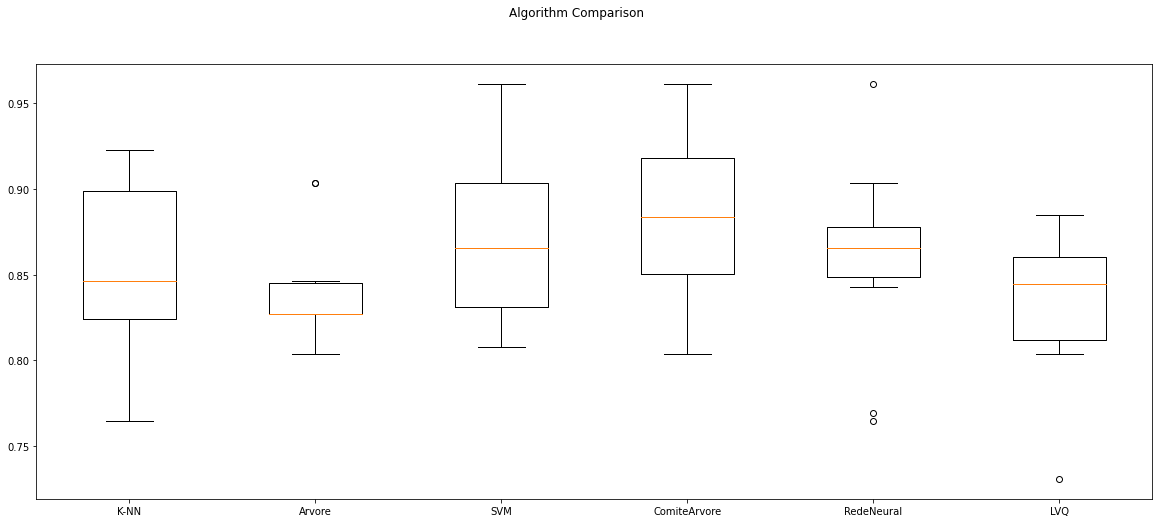

In [18]:
fig = plt.figure(figsize = (20,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()	